In [1]:
# Imports modules and packages
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, AveragePooling1D, Normalization, SpatialDropout1D

# Disable warns
pd.options.mode.chained_assignment = None  # default='warn'

# Set seaborn
sns.set()

2024-12-07 14:25:16.429745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 14:25:16.430188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 14:25:16.873168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 14:25:18.089486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 14:25:30.929575: W tensorflow/compiler/tf2

## Import dataset

### Data Train

In [2]:
# Read the dataset
data = pd.read_csv('../csv_files/IoT_Botnet_Full5pc_train.csv', low_memory=False)

# Select the 'proto' and 'state' values that I want
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='igmp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['attack']]

# Select interested data features
data_features=data[['proto','saddr','sport','daddr','dport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

# Filling NaN values with -1
data_features = data_features.fillna(value=-1)
"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(".")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(":")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(".")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(":")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dport'] = data_features['dport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dport'] = data_features['dport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dport'] = data_features['dport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['saddr'] = data_features['saddr'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['daddr'] = data_features['daddr'].astype(int)
data_features['dport'] = data_features['dport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)

# Generate 2 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(14, 'state_PAR', auxCol, True)
    
# Transform to One hot encoding
data_features=pd.get_dummies(data_features)
data_labels = pd.get_dummies(data_labels)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)

x_train, y_train = data_features, data_labels

### Data Test

In [9]:
# Read the dataset
data = pd.read_csv('~/04_Semester_4/revisi/csv_files/IoT_Botnet_Full5pc_test.csv', low_memory=False)

# Select the 'proto' and 'state'
data = data.loc[(data['proto'] == 'tcp') | (data['proto'] =='udp') | (data['proto'] =='icmp') | (data['proto'] =='arp') | (data['proto'] =='igmp'), :]
data = data.loc[(data['state'] == 'RST') | (data['state'] =='REQ') | (data['state'] =='INT') | (data['state'] =='FIN') | (data['state'] =='CON') | (data['state'] =='ECO') | (data['state'] =='ACC') | (data['state'] =='PAR'), :]

# Extracting dataset labels
data_labels=data[['attack']]

# Select the data features
data_features=data[['proto','saddr','sport','daddr','dport','spkts','dpkts','sbytes','dbytes','state','stime','ltime','dur']]

# Filling NaN values with -1
data_features = data_features.fillna(value=-1)

"""PREPROCESSING"""

# Preprocess IP and ports features
# IP Source Address
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(".")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: x.split(":")[-1])
data_features['saddr'] = data_features['saddr'].apply(lambda x: int(x, 16))

# IP Destination Address
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(".")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: x.split(":")[-1])
data_features['daddr'] = data_features['daddr'].apply(lambda x: int(x, 16))

# Ports
data_features['sport'] = data_features['sport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)
data_features['dport'] = data_features['dport'].apply(lambda x: x.replace('0x','') if "0x" in str(x) else x)

# Convert all ports with 0 decimal, and HEX to DEC
data_features['sport'] = data_features['sport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['sport'] = data_features['sport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

data_features['dport'] = data_features['dport'].apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))
data_features['dport'] = data_features['dport'].apply(lambda x: -1 if str(x).isalpha()==True else int(x,16))

# Convert field to int format
data_features['saddr'] = data_features['saddr'].astype(int)
data_features['sport'] = data_features['sport'].astype(int)
data_features['daddr'] = data_features['daddr'].astype(int)
data_features['dport'] = data_features['dport'].astype(int)

# Convert some fields to logarithmic
log1p_col = ['dur', 'sbytes', 'dbytes', 'spkts']

for col in log1p_col:
    data_features[col] = data_features[col].apply(np.log1p)

# Generate 2 new columns to fit with training
auxCol=data_features['sbytes']
auxCol=0
data_features.insert(13, 'proto_igmp', auxCol, True)
data_features.insert(14, 'state_PAR', auxCol, True)
    
# Transform to One hot encoding
data_features=pd.get_dummies(data_features)
data_labels = pd.get_dummies(data_labels)

# Normalize all data features
data_features = StandardScaler().fit_transform(data_features)

#Add dimension to data features
data_features = np.expand_dims(data_features, axis=2)

x_test, y_test = data_features, data_labels

### Define the Model

In [14]:
# Clear Session & Memory Growth
def clear_session():
    tf.keras.backend.clear_session()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
    return

# Early Stopping

filepath = '../tmp/checkpoint.model_iotbot_5pc.keras' 
callbacks = [
        keras.callbacks.EarlyStopping(
            monitor = 'val_loss', 
            patience = 5 
        ),
        keras.callbacks.ModelCheckpoint(
            filepath = filepath, 
            monitor = 'val_loss', 
            save_best_only = True)]

In [16]:
# Model building and definition
def model_cnn():
    # define the inputs
    inputs = (24,1)
    # define the model architecture
    model = Sequential()
    # Layer 1 : Conv1D, Normalization, AveragePooling and Dropout
    model.add(layers.Conv1D(filters=64,  input_shape=inputs, kernel_size=(24), activation='relu', padding='same'))
    model.add(layers.Normalization())
    model.add(layers.MaxPooling1D(pool_size=(2),padding='same'))
    model.add(layers.SpatialDropout1D(0.05))
    # Layer 2 : Conv1D, Normalization, AveragePooling and Dropout
    model.add(layers.Conv1D(filters=64, kernel_size=(24), activation='relu', padding='same'))
    model.add(layers.Normalization())
    model.add(layers.MaxPooling1D(pool_size=(2),padding='same'))
    model.add(layers.SpatialDropout1D(0.05)) 
    # Flatten layer
    model.add(layers.Flatten())
    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    #Adding the output layer
    model.add(Dense(1, activation='sigmoid'))
    # Adding the optimizer
    adam = keras.optimizers.Adam(learning_rate=2e-5)
    loss = keras.losses.BinaryCrossentropy()
    model.compile(optimizer = adam,
                  loss = loss,
                  metrics = ['accuracy'])

    return model

### Train the Model

In [18]:
# Clear session and Memory Growth
clear_session()

# Create a Strategy.
mixed_precision.set_global_policy('mixed_float16')

if tf.config.list_physical_devices('GPU'):
    strategy = tf.distribute.MirroredStrategy()
else:  # Use the Default Strategy
    strategy = tf.distribute.get_strategy()

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    model=model_cnn()
# Train the model on all available devices.
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=15, batch_size=256, callbacks=callbacks)

Physical devices cannot be modified after being initialized
Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce MX110, compute capability 5.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2024-12-07 14:28:12.743035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-07 14:28:13.332117: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 281048064 exceeds 10% of free system memory.
2024-12-07 14:28:13.969744: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 281048064 exceeds 10% of free system memory.
2024-12-07 14:28:14.385992: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 281048064 exceeds 10% of free system memory.


Epoch 1/15
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2024-12-07 14:28:25.464815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-07 14:28:37.518129: I external/local_xla/xla/service/service.cc:168] XLA service 0x77d026498c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-07 14:28:37.518173: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX110, Compute Capability 5.0
2024-12-07 14:28:38.977536: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733556520.597235    4192 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11436/11436 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9994INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
11436/11436 [==============================] - 524s 44ms/step - loss: 0.0110 - accuracy: 0.9994 - val_loss: 8.3456e-04 - val_accuracy: 0.9999
Epoch 2/15
11436/11436 [==============================] - 486s 43ms/step - loss: 3.3708e-04 - accuracy: 0.9999 - val_loss: 3.2243e-04 - val_accuracy: 0.9999
Epoch 3/15
11436/11436 [==============================] - 496s 43ms/step - loss: 1.9785e-04 - accuracy: 0.9999 - val_loss: 1.5313e-04 - val_accuracy: 0.9999
Epoch 4/15
11436/11436 [==============================] - 497s 43ms/step - loss: 1.3600e-04 - accuracy: 1.0000 - val_loss: 9.5239e-05 - val_accuracy: 1.0000
Epoch 5/15
11436/11

In [19]:
results = model.evaluate(x_test, y_test, verbose=1)
print("test loss, test acc:", results)

22874/22874 [==============================] - 122s 5ms/step - loss: 5.2662e-05 - accuracy: 1.0000
test loss, test acc: [5.266158768790774e-05, 0.9999849796295166]


In [20]:
results = model.evaluate(x_test, y_test, verbose=1)
print("test loss, test acc:", results)

22874/22874 [==============================] - 122s 5ms/step - loss: 5.2662e-05 - accuracy: 1.0000
test loss, test acc: [5.266158768790774e-05, 0.9999849796295166]


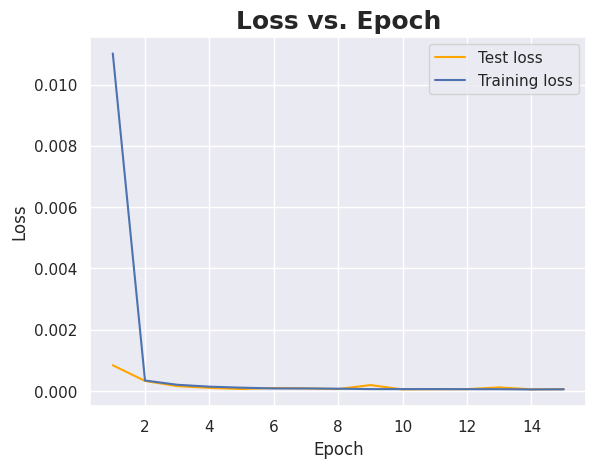

In [21]:
# summarize history for loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
x = list(range(1, len(test_loss) + 1))
plt.plot(x, test_loss, color = 'orange', label = 'Test loss')
plt.plot(x, train_loss, label = 'Training loss')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch', weight='bold', fontsize=18)
plt.show()

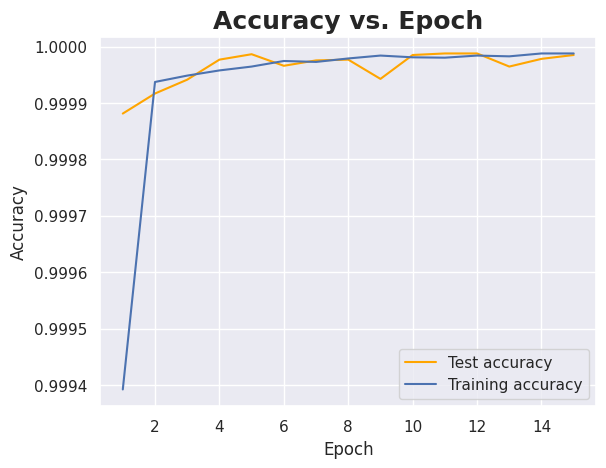

In [22]:
# summarize history for accuracy
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
x = list(range(1, len(test_acc) + 1))
plt.plot(x, test_acc, color = 'orange', label = 'Test accuracy')
plt.plot(x, train_acc, label = 'Training accuracy')
plt.legend()
plt.grid(visible=True)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch', weight='bold', fontsize=18)
plt.show()

In [23]:
# Prediction
predicted = model.predict(x_test)

22874/22874 [==============================] - 86s 4ms/step


In [24]:
df = pd.DataFrame(y_test)
df['predicted'] = predicted

In [25]:
from sklearn.metrics import det_curve
fpr, fnr, threshold = det_curve(y_test, np.round(predicted))
print("FPR :", fpr)
print("FNR :", fnr)

FPR : [1.         0.01886792]
FNR : [0.00000000e+00 1.22977364e-05]


In [26]:
cf = confusion_matrix(y_test, np.round(predicted))

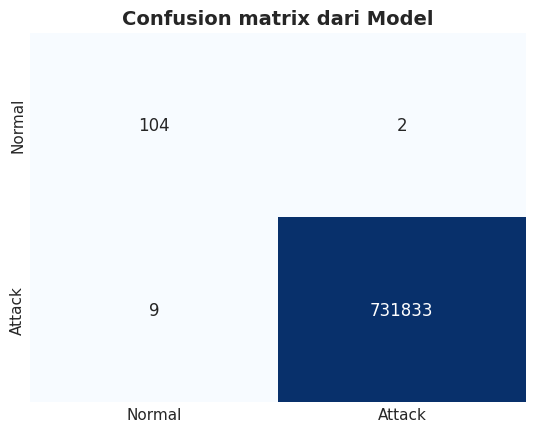

In [27]:
cmatrix_df = pd.DataFrame(cf, index = ['Normal', 'Attack'], columns = ['Normal', 'Attack'])
plt.title('Confusion matrix dari Model', weight='bold', fontsize=14)
plt.tick_params(length=0)
plt.xlabel('Attacks')
plt.ylabel('Predicted Attacks')
sns.heatmap(cmatrix_df, annot=True, fmt="d", cbar=False, cmap='Blues')
plt.show()

In [28]:
# Precision, Recall & F1 Score
class_report = classification_report(y_test, np.round(predicted))
print(class_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       106
           1       1.00      1.00      1.00    731842

    accuracy                           1.00    731948
   macro avg       0.96      0.99      0.97    731948
weighted avg       1.00      1.00      1.00    731948



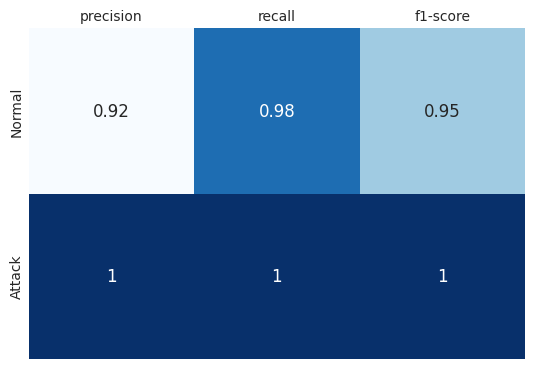

In [29]:
# Precision, Recall & F1-Score
class_report = classification_report(y_test, np.round(predicted), target_names = ['Normal', 'Attack'],output_dict=True) 
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
plt.tick_params(length=0)
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :-3].T, square=True, cbar=False,cmap='Blues', annot=True) 
plt.show()

In [30]:
#Evaluate the model
#model = load_model(('/home/riki/project_dl/finale/model/cnn1d_base_model.keras')
model.save('~/04_Semester_4/revisi/model_iotbot_10_512.keras')

In [31]:
# adding normal column in data label
normal=data_labels['attack']
normal=normal.replace(1,2)
normal=normal.replace(0,1)
normal=normal.replace(2,0)
data_labels.insert(1, 'normal', normal)

In [32]:
df1 = pd.DataFrame(np.round(predicted))
df1.index = data.index
df1.columns = ['pred_attack']
df1['pred_normal'] = 1- df1['pred_attack']
df1['attack']=data['attack']
df1['category']=data['category']
df1['normal']=data_labels['normal']
df1.head()

,pred_attack,pred_normal,attack,category,normal
0,1.0,0.0,1,DoS,0
1,1.0,0.0,1,DDoS,0
2,1.0,0.0,1,DDoS,0
3,1.0,0.0,1,DDoS,0
4,1.0,0.0,1,DoS,0


In [33]:
df1.value_counts('category')

category
DDoS              385282
DoS               330097
Reconnaissance     16447
Normal               106
Theft                 16
Name: count, dtype: int64

In [34]:
dff1=df1
df1=pd.get_dummies(df1)
df1=round(df1)
df1

,pred_attack,pred_normal,attack,normal,category_DDoS,category_DoS,category_Normal,category_Reconnaissance,category_Theft
0,1.0,0.0,1,0,False,True,False,False,False
1,1.0,0.0,1,0,True,False,False,False,False
2,1.0,0.0,1,0,True,False,False,False,False
3,1.0,0.0,1,0,True,False,False,False,False
4,1.0,0.0,1,0,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...
733699,1.0,0.0,1,0,False,True,False,False,False
733700,1.0,0.0,1,0,False,True,False,False,False
733701,1.0,0.0,1,0,False,True,False,False,False
733702,1.0,0.0,1,0,True,False,False,False,False


In [35]:
ddos=df1.loc[df1['category_DDoS'] == 1]
ddos=ddos[['pred_attack', 'pred_normal', 'attack', 'normal']]
ddos_pred=ddos[['pred_attack','pred_normal']]
ddos_check=ddos[['attack','normal']]

normal=df1.loc[df1['category_Normal'] == 1]
normal=normal[['pred_attack', 'pred_normal', 'attack', 'normal']]
normal_pred=normal[['pred_attack','pred_normal']]
normal_check=normal[['attack','normal']]

theft=df1.loc[df1['category_Theft'] == 1]
theft=theft[['pred_attack', 'pred_normal', 'attack', 'normal']]
theft_pred=theft[['pred_attack','pred_normal']]
theft_check=theft[['attack','normal']]

reconnaissance=df1.loc[df1['category_Reconnaissance'] == 1]
reconnaissance=reconnaissance[['pred_attack', 'pred_normal', 'attack', 'normal']]
reconnaissance_pred=reconnaissance[['pred_attack','pred_normal']]
reconnaissance_check=reconnaissance[['attack','normal']]

dos=df1.loc[df1['category_DoS'] == 1]
dos=dos[['pred_attack', 'pred_normal', 'attack', 'normal']]
dos_pred=dos[['pred_attack','pred_normal']]
dos_check=dos[['attack','normal']]

In [36]:
#Correctly detected
countdata=pd.DataFrame()
normal_c = normal['pred_normal'] * normal['normal']
ddos_c = ddos['pred_attack'] * ddos['attack']
theft_c = theft['pred_attack'] * theft['attack']
reconnaissance_c = reconnaissance['pred_attack'] * reconnaissance['attack']
dos_c = dos['pred_attack'] * dos['attack']

In [37]:
# Count 0 and 1
normal_c0 = (normal_c == 0).sum()
normal_c1 = len(normal) - normal_c0

ddos_c0 = (ddos_c == 0).sum()
ddos_c1 = len(ddos) - ddos_c0

theft_c0 = (theft_c == 0).sum()
theft_c1 = len(theft) - theft_c0

reconnaissance_c0 = (reconnaissance_c == 0).sum()
reconnaissance_c1 = len(reconnaissance) - reconnaissance_c0

dos_c0 = (dos_c == 0).sum()
dos_c1 = len(dos) - dos_c0

In [38]:
normal_0, normal_1 = normal_c0*100 / len(normal), normal_c1*100 / len(normal)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(normal_0, normal_1))

There are 1.89 % of NO detected and 98.11 % of detected samples


In [39]:
ddos_0, ddos_1 = ddos_c0*100 / len(ddos), ddos_c1*100 / len(ddos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(ddos_0, ddos_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [40]:
theft_0, theft_1 = theft_c0*100 / len(theft), theft_c1*100 / len(theft)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(theft_0, theft_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [41]:
reconnaissance_0, reconnaissance_1 = reconnaissance_c0*100 / len(reconnaissance), reconnaissance_c1*100 / len(reconnaissance)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(reconnaissance_0, reconnaissance_1))

There are 0.05 % of NO detected and 99.95 % of detected samples


In [42]:
dos_0, dos_1 = dos_c0*100 / len(dos), dos_c1*100 / len(dos)
print("There are {:.2f} % of NO detected and {:.2f} % of detected samples".format(dos_0, dos_1))

There are 0.00 % of NO detected and 100.00 % of detected samples


In [43]:
summary = pd.DataFrame({"Traffic":
                   ["Normal", "ddos", "theft", "Reconnaissance", "DoS"],
                   "Detected %": [normal_1, ddos_1, theft_1, reconnaissance_1, dos_1],
                   "No Detected %": [normal_0, ddos_0, theft_0, reconnaissance_0, dos_0],
                   "Detected Samples": [normal_c1, ddos_c1, theft_c1, reconnaissance_c1, dos_c1],
                   "No Detected Samples": [normal_c0, ddos_c0, theft_c0, reconnaissance_c0, dos_c0]})

In [44]:
dff1['category_pred'] = np.where(((df1['attack'] == 1) & (df1['pred_attack'] == 1)) | ((df1['normal'] == 1) & (df1['pred_normal'] == 1)), 'Detected', 'No Detected')

In [45]:
data_plot=dff1[['category', 'category_pred']]

In [46]:
data_plot

,category,category_pred
0,DoS,Detected
1,DDoS,Detected
2,DDoS,Detected
3,DDoS,Detected
4,DoS,Detected
...,...,...
733699,DoS,Detected
733700,DoS,Detected
733701,DoS,Detected
733702,DDoS,Detected


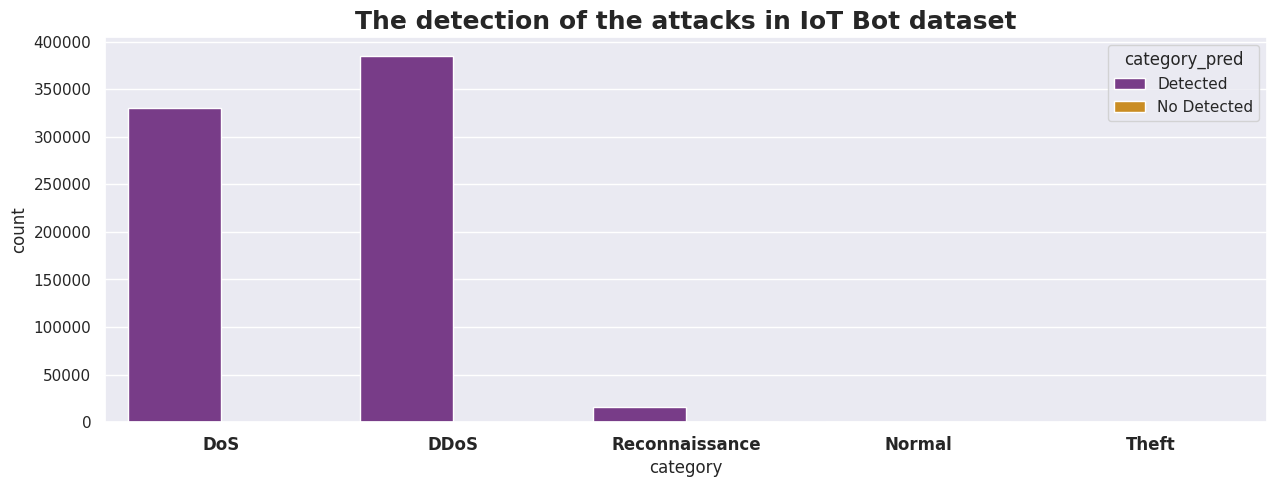

In [47]:
# Plotting target label distribution
plt.figure(figsize=(15,5))
sns.set_theme(style="darkgrid")
sns.countplot(x=data_plot['category'], data=data_plot,palette='CMRmap', hue=data_plot['category_pred'])
plt.title('The detection of the attacks in IoT Bot dataset', weight='bold', fontsize='18')
plt.xticks(weight='bold', fontsize=12)
plt.show()

In [48]:
summary

,Traffic,Detected %,No Detected %,Detected Samples,No Detected Samples
0,Normal,98.113208,1.886792,104,2
1,ddos,100.000000,0.000000,385282,0
2,theft,100.000000,0.000000,16,0
3,Reconnaissance,99.945279,0.054721,16438,9
4,DoS,100.000000,0.000000,330097,0


In [49]:
summary.to_csv('~/04_Semester_4/revisi/csv_files/iotbot_model_24_512.csv', index=False)

In [50]:
model.save('model_iotbot_24_512.keras')

In [ ]:
new_model = tf.keras.models.load_model('my_model.keras')